# ***Hopfield Networks for Associative Memory***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

### Hopfield network and Hebbian learning

In [ ]:
class Hopfield():
    def __init__(self, n_nodes, weights=None):
        self.n_nodes = n_nodes
        if weights is not None:
            self.W = weights
        else:
            self.W = np.zeros((self.n_nodes, self.n_nodes))

    def train(self, X, remove_self=False, activity=None):
        """
        Updates weights with Hebbian rule.
        X is a matrix with patterns as columns.
        """
        if activity is None:
            self.W += X @ X.T  # Hebbian rule
        else:
            self.W += (X - activity) @ (X - activity).T  # Centered Hebbian rule

        if remove_self:
                np.fill_diagonal(self.W, 0)  # Remove self-connections

    def compute_energy(self, X):
        """
        Computes one energy per pattern.
        """
        return -0.5 * np.sum(X * (self.W @ X), axis=0)  # Extract energy per pattern, output (P,)

    def recall(self, X, mode="synchronous", plot=False, display=False, plot_degraded=False, max_iterations=10000, no_change_limit=10, verbose=True, theta=None):
        """
        Performs recall using synchronous or asynchronous updates until energy stabilizes.
        Stops if energy does not decrease for 'no_change_limit' iterations on all the patterns.
        Can display the updates when only one pattern is provided.
        """
        X = X.copy()
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        P = X.shape[1]  # Number of patterns
        energies = [self.compute_energy(X)]  # Store energy of each pattern at each step
        step = 0
        no_change_counter = 0

        if mode == "asynchronous":
            while no_change_counter < no_change_limit and step < max_iterations:
                i = np.random.randint(0, self.n_nodes)  # Pick a random neuron
                X[i] = np.sign(np.dot(self.W[i], X))  # Update one single neuron
                energies.append(self.compute_energy(X))  # Store energy of each pattern

                if np.all(energies[-1] >= energies[-2]):  # Check if all patterns are stable
                    no_change_counter += 1
                else:
                    no_change_counter = 0

                if display and P == 1:  # Only display if one pattern is provided
                    if step % 500 == 0:
                        print(f"Step {step}: Energy = {energies[-1]}")
                        display_patterns([X], step=step)

                elif display and P > 1: # Handle error when more than one pattern is provided
                    print(f"Error: More than one pattern provided ({P}), cannot display the pattern updates.")
                    break

                step += 1

        elif theta is None:  # Synchronous updates
            while no_change_counter < no_change_limit and step < max_iterations:
                X = np.sign(np.dot(self.W, X))  # Update all nodes at once
                energies.append(self.compute_energy(X))  # Store energy of each pattern

                if np.all(energies[-1] >= energies[-2]):
                    no_change_counter += 1
                else:
                    no_change_counter = 0
                step += 1

        else:  # Centered synchronous updates
            while no_change_counter < no_change_limit and step < max_iterations:
                X = 0.5 + 0.5*np.sign(np.dot(self.W, X) - theta)  # Updated rule with biais
                energies.append(self.compute_energy(X))  # Store energy of each pattern

                if np.all(energies[-1] >= energies[-2]):
                    no_change_counter += 1
                else:
                    no_change_counter = 0
                step += 1

        if verbose:
            print(f"Converged after {step} steps. (Stopped due to {'stable energy' if no_change_counter >= no_change_limit else 'max iterations'})")

        if plot:
            self.plot_energy(energies)

        if plot_degraded:
            self.plot_degraded(energies)

        return X

    def plot_energy(self, energies):
        energies = np.array(energies)  # Convert to numpy array (shape: iterations x patterns)
        P = energies.shape[1]  # Number of patterns

        plt.figure(figsize=(8, 5))
        for p in range(P):
            plt.plot(energies[:, p], label=f'Pattern {p + 1}')

        plt.xlabel('Step')
        plt.ylabel('Energy')
        plt.title('Energy vs. Step for Each Pattern')
        plt.legend()
        plt.show()

    def plot_degraded(self, energies):
        """
        Plots a comparison between the original and degraded patterns.
        """
        energies = np.array(energies)  # Convert to numpy array (shape: iterations x patterns)
        P = energies.shape[1]  # Number of patterns

        plt.figure(figsize=(8, 5))

        plt.plot(energies[:, 0], label=f'Input pattern')
        plt.plot(energies[:, 1], label=f'Degraded pattern')

        plt.xlabel('Step')
        plt.ylabel('Energy')
        plt.title('Energy vs. Step for Each Pattern')
        plt.legend()
        plt.show()

    def find_attractors(self, num_tests=1000):
        """
        Estimates the number of attractors in the network.
        """
        attractors = [] # List of unique attractors
        for _ in range(num_tests):
            test_pattern = np.random.choice([-1, 1], size=self.n_nodes)  # Random start state
            final_pattern = tuple(self.recall(test_pattern, verbose=False))
            if final_pattern not in attractors:
                attractors.append(final_pattern)
        print(f"Number of attractors: {len(attractors)}")

## 1) Convergence and attractors

In [ ]:
# Input patterns
x1 = np.array([-1, -1,  1, -1,  1, -1, -1,  1])
x2 = np.array([-1, -1, -1, -1, -1,  1, -1, -1])
x3 = np.array([-1,  1,  1, -1, -1,  1, -1,  1])

X = np.column_stack((x1, x2, x3))
print(f"Patterns: {X}")

# Noisy input patterns
x1d = [1, -1, 1, -1, 1, -1, -1, 1]
x2d = [1, 1, -1, -1, -1, 1, -1, -1]
x3d = [1, 1, 1, -1, 1, 1, -1, 1]
Xd = np.column_stack((x1d, x2d, x3d))
print(f"Noisy patterns: {Xd}")

# Model
hopfield_net = Hopfield(n_nodes=8)

# Train network
hopfield_net.train(X)

# Test recall with same patterns
print(f"Recall with input patterns: {hopfield_net.recall(X)}")

# Test with noisy patterns
print(f"Recall with noisy patterns: {hopfield_net.recall(Xd)}")

Patterns: [[-1 -1 -1]
 [-1 -1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1 -1 -1]
 [-1  1  1]
 [-1 -1 -1]
 [ 1 -1  1]]
Noisy patterns: [[ 1  1  1]
 [-1  1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1 -1  1]
 [-1  1  1]
 [-1 -1 -1]
 [ 1 -1  1]]
Converged after 10 steps. (Stopped due to stable energy)
Recall with input patterns: [[-1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1.  1.]
 [-1. -1. -1.]
 [ 1. -1. -1.]
 [-1.  1.  1.]
 [-1. -1. -1.]
 [ 1. -1.  1.]]
Converged after 13 steps. (Stopped due to stable energy)
Recall with noisy patterns: [[-1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1.  1.]
 [-1. -1. -1.]
 [ 1. -1. -1.]
 [-1.  1.  1.]
 [-1. -1. -1.]
 [ 1. -1.  1.]]


In [ ]:
hopfield_net.find_attractors()

Number of attractors: 16


In [ ]:
# Input patterns
x1 = np.array([-1, -1,  1, -1,  1, -1, -1,  1]).reshape(-1,1)
X = x1
print(f"Patterns: {X}")

# More noisy input patterns
x1d = np.array([1, 1, -1, 1, -1, -1, -1, 1]).reshape(-1,1)
Xd = x1d
print(f"Super noisy patterns: {Xd}")

# Test recall with same patterns
print(f"Recall with input pattern: {hopfield_net.recall(X)}")

# Test with noisy patterns
print(f"Recall with super noisy pattern: {hopfield_net.recall(Xd)}")
hopfield_net.find_attractors()

Patterns: [[-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]]
Super noisy patterns: [[ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]]
Converged after 10 steps. (Stopped due to stable energy)
Recall with input pattern: [[-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]
Converged after 12 steps. (Stopped due to stable energy)
Recall with super noisy pattern: [[ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]]
Number of attractors: 16


## 2) Sequential Update

In [ ]:
def display_patterns(patterns, step=None):
    """
    Displays each pattern in patterns as a 32 x 32 image.
    """
    # If there's only one pattern, axes will not be an array
    num_patterns = len(patterns)

    fig, axes = plt.subplots(1, num_patterns, figsize=(12, 4))

    # Ensure axes is iterable even for a single pattern
    if num_patterns == 1:
        axes = [axes]

    # Loop through each pattern and display it
    for i, pattern in enumerate(patterns):
        image = pattern.reshape(32, 32)

        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

        if step:
          axes[i].set_title(f"Step {step}")

    plt.show()

Saving pict.dat to pict.dat


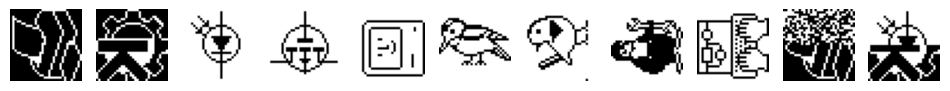

In [ ]:
# Upload the file
uploaded = files.upload()

# Read raw data
data = np.loadtxt('pict.dat', delimiter=',')

# Reshape the data nine 1024-dimensional patterns
patterns = data.reshape((11, 1024))

# Extract the first 3 patterns
patterns_extracted = patterns[:3]

# Display
display_patterns(patterns)

Converged after 10 steps. (Stopped due to stable energy)
Recalled from input patterns:


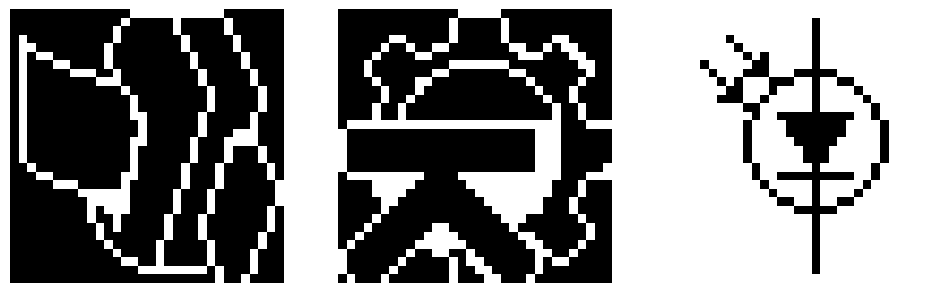

Degraded pattern 1:


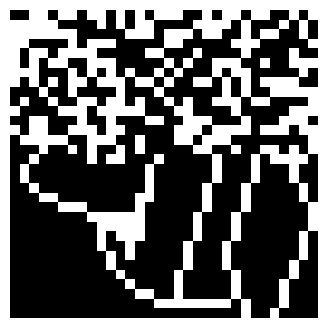

Converged after 2 steps. (Stopped due to stable energy)
Recalled from degraded pattern 1:


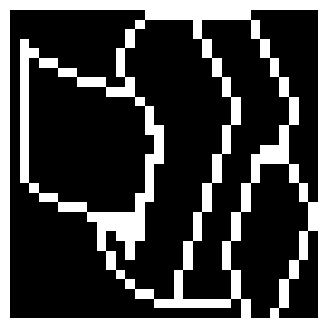

In [ ]:
# Larger model
hopfield_large = Hopfield(n_nodes=1024)

# Training
hopfield_large.train(patterns_extracted.T)

# Recalling
recalled_large = hopfield_large.recall(patterns_extracted.T)
print("Recalled from input patterns:")
display_patterns(recalled_large.T)

# Degraded pattern 1
p10 = patterns[9]
print("Degraded pattern 1:")
display_patterns([p10])

# Recalling degraded pattern 1
recall_p10 = hopfield_large.recall(p10.T, no_change_limit=1)
print("Recalled from degraded pattern 1:")
display_patterns([recall_p10])

Updates on degraded pattern 1:


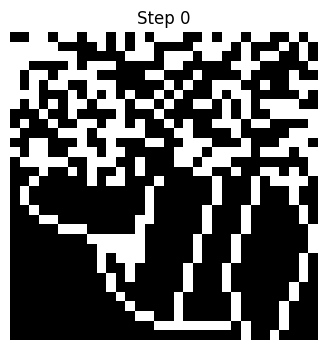

Step 0: Energy = [-212982.]


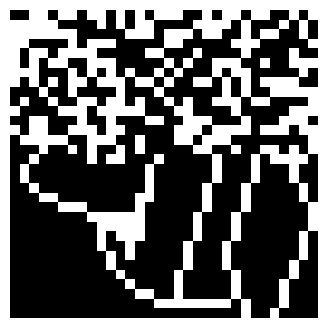

Step 500: Energy = [-382952.]


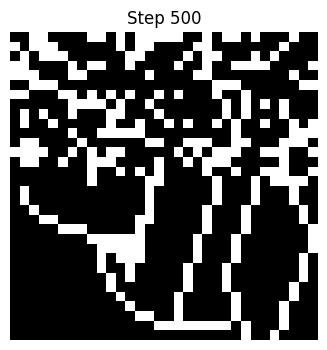

Step 1000: Energy = [-494518.]


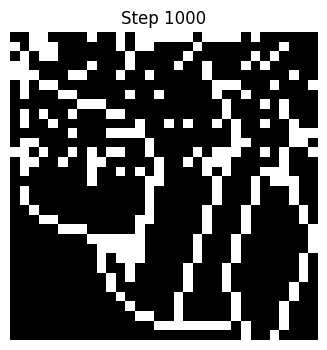

Step 1500: Energy = [-581542.]


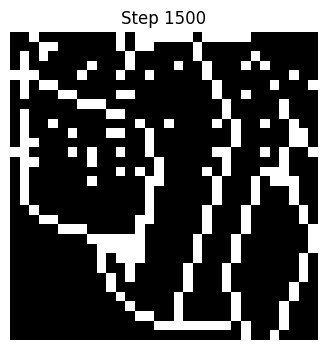

Step 2000: Energy = [-657840.]


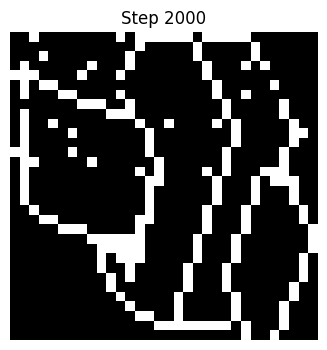

Step 2500: Energy = [-693654.]


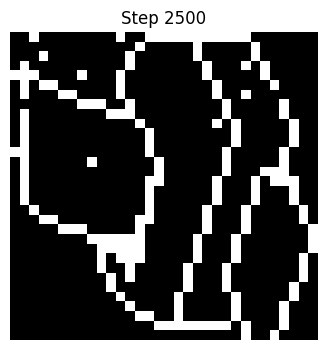

Step 3000: Energy = [-698518.]


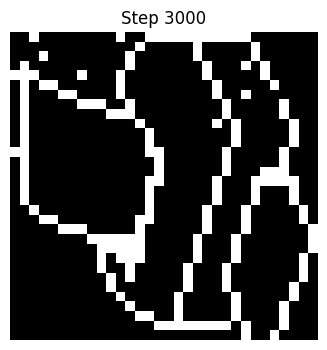

Step 3500: Energy = [-713904.]


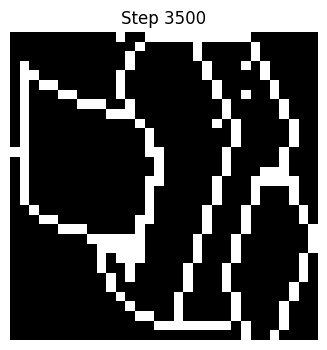

Step 4000: Energy = [-725382.]


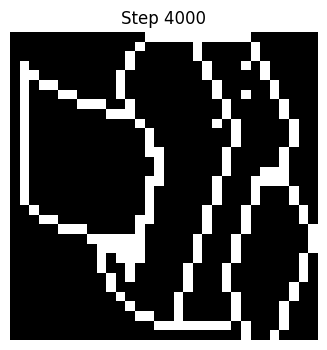

Step 4500: Energy = [-729232.]


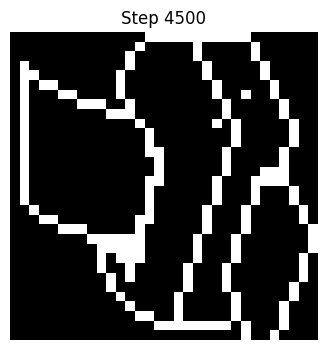

Step 5000: Energy = [-733094.]


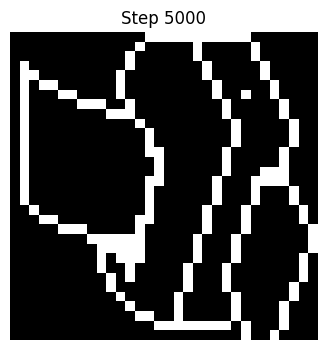

Step 5500: Energy = [-733094.]


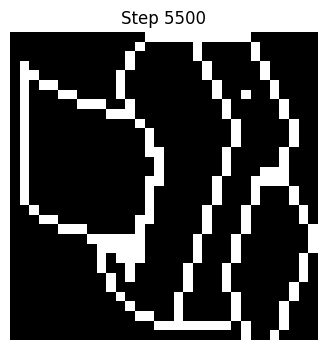

Step 6000: Energy = [-736968.]


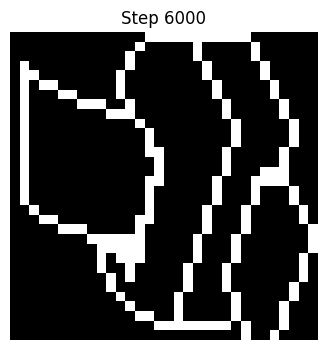

Step 6500: Energy = [-736968.]


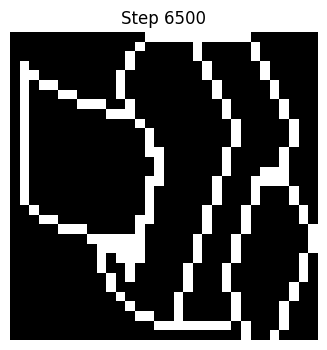

Converged after 6646 steps. (Stopped due to stable energy)


In [ ]:
# Larger model
hopfield_async = Hopfield(n_nodes=1024)

# Training
hopfield_async.train(patterns_extracted.T)

# Recalling
p10 = patterns[9]
print("Updates on degraded pattern 1:")
display_patterns([p10], step="0")
recalled_async = hopfield_async.recall(p10.T, mode="asynchronous", display=True, no_change_limit=1000)

## 3) Energy

Training patterns:


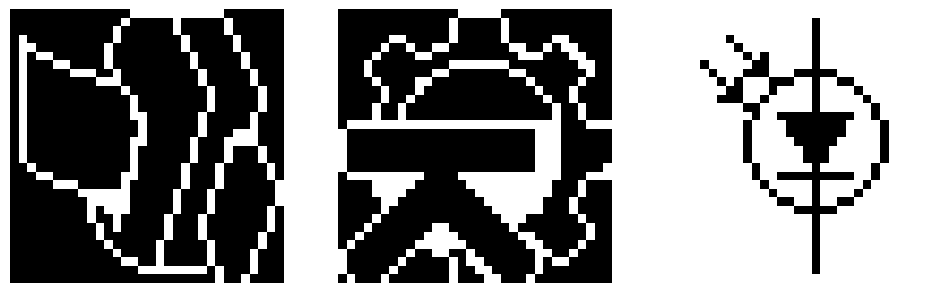

Converged after 2000 steps. (Stopped due to stable energy)


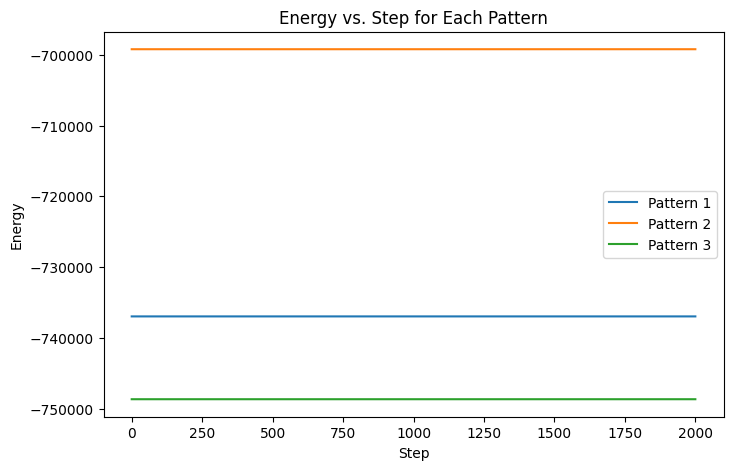

array([[-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       ...,
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.]])

In [ ]:
# Larger model
hopfield_large = Hopfield(n_nodes=1024)

# Training
hopfield_large.train(patterns_extracted.T)

# Training patterns
training_patterns = patterns[:3]
print("Training patterns:")
display_patterns(training_patterns)

# Recalling patterns
hopfield_large.recall(training_patterns.T, plot=True, mode="asynchronous", no_change_limit=2000, max_iterations=8000)

Compared patterns:


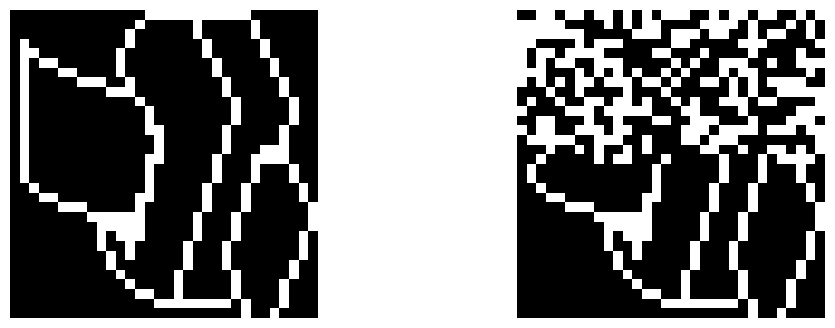

Converged after 8724 steps. (Stopped due to stable energy)


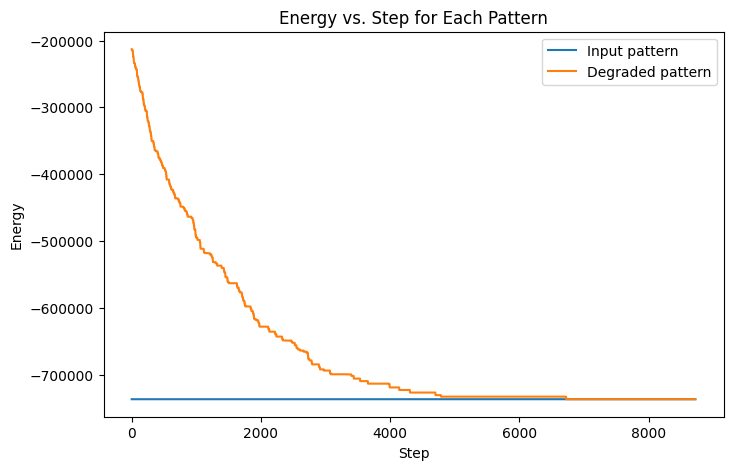

array([[-1., -1.],
       [-1., -1.],
       [-1., -1.],
       ...,
       [-1., -1.],
       [-1., -1.],
       [-1., -1.]])

In [ ]:
# Larger model
hopfield_large = Hopfield(n_nodes=1024)

# Training
hopfield_large.train(patterns_extracted.T)

# Comparison with degraded patterns
comp_p1 = patterns[[0,9],:]
print("Compared patterns:")
display_patterns(comp_p1)

# Recalling both patterns
hopfield_large.recall(comp_p1.T, plot_degraded=True, mode="asynchronous", no_change_limit=2000)

Compared patterns:


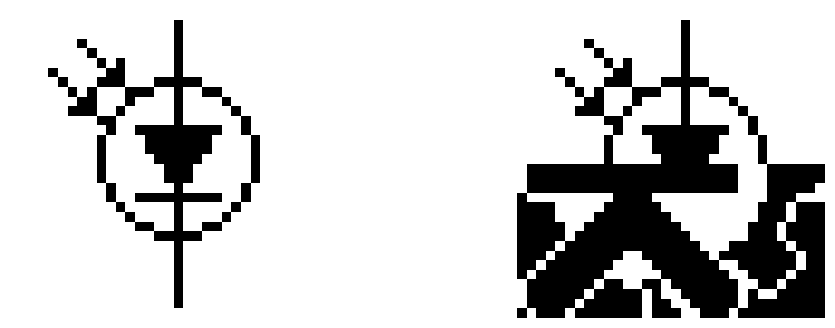

Converged after 8464 steps. (Stopped due to stable energy)


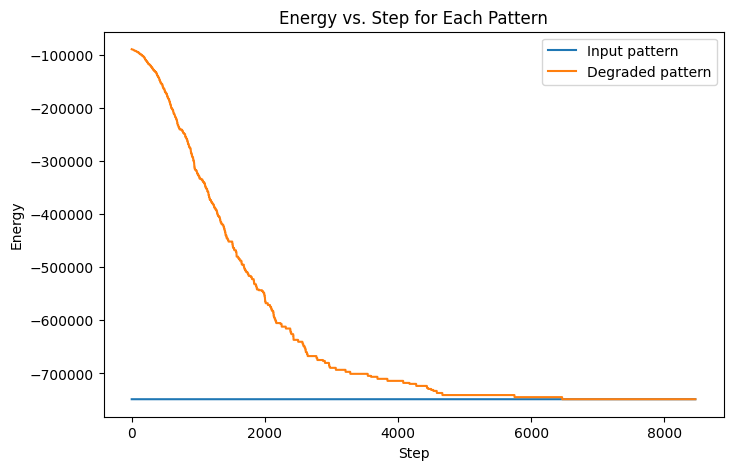

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [ ]:
# Larger model
hopfield_large = Hopfield(n_nodes=1024)

# Training
hopfield_large.train(patterns_extracted.T)

# Comparison with degraded patterns
comp_p3 = patterns[[2,10],:]
print("Compared patterns:")
display_patterns(comp_p3)

# Recalling both patterns
hopfield_large.recall(comp_p3.T, plot_degraded=True, mode="asynchronous", no_change_limit=2000)

Converged after 8000 steps. (Stopped due to max iterations)


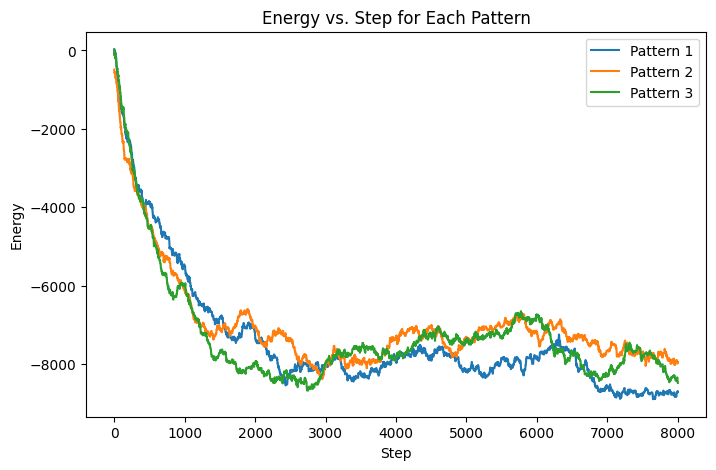

array([[-1.,  1., -1.],
       [-1.,  1.,  1.],
       [-1.,  1.,  1.],
       ...,
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [-1., -1., -1.]])

In [ ]:
# Personalised random weight matrix
weights = np.random.normal(loc=0, scale=1, size=(1024, 1024))

# New model
hopfield_uni = Hopfield(n_nodes=1024, weights=weights)

# Recalling patterns
hopfield_uni.recall(patterns_extracted.T, plot=True, mode="asynchronous", no_change_limit=2000, max_iterations=8000)

Step 0: Energy = [-102.89592174]


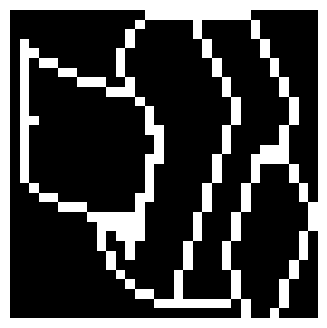

Step 500: Energy = [-5638.02311714]


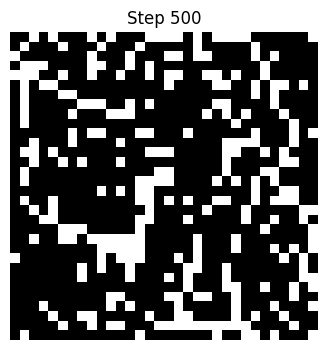

Step 1000: Energy = [-9221.75799844]


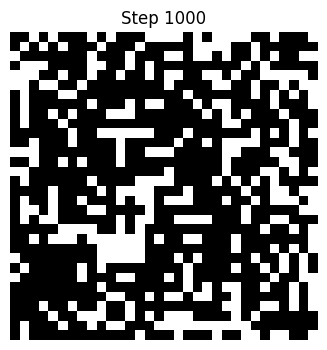

Step 1500: Energy = [-10883.44301956]


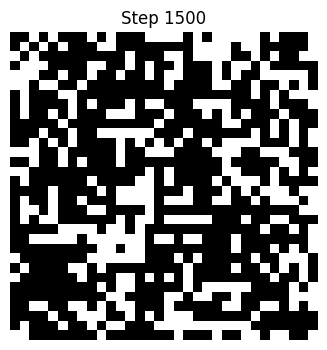

Step 2000: Energy = [-12049.4081319]


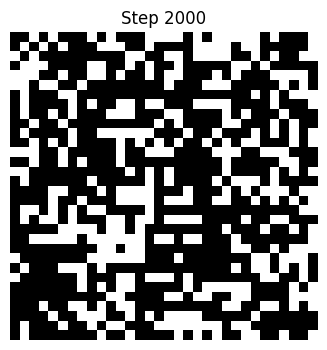

Step 2500: Energy = [-12839.37823852]


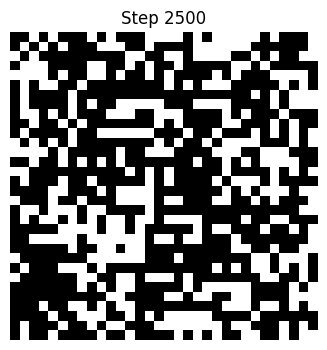

Step 3000: Energy = [-13498.90323115]


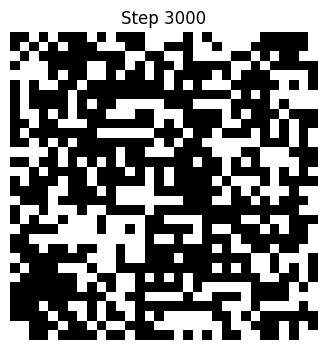

Step 3500: Energy = [-13853.09374037]


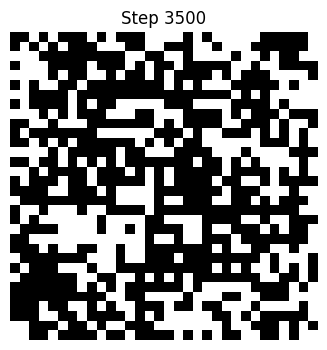

Step 4000: Energy = [-14083.6006323]


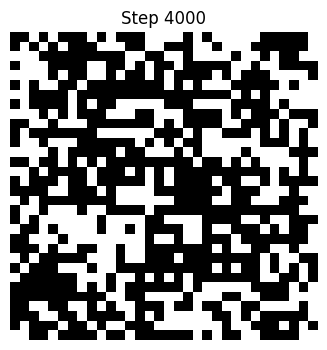

Step 4500: Energy = [-14291.99269567]


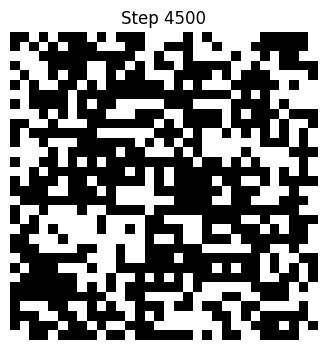

Step 5000: Energy = [-14515.8233394]


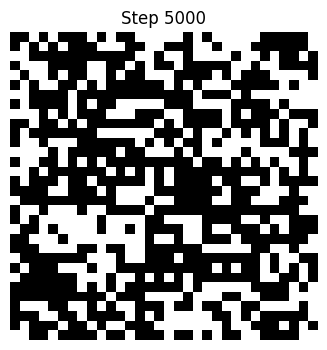

Step 5500: Energy = [-14720.09898416]


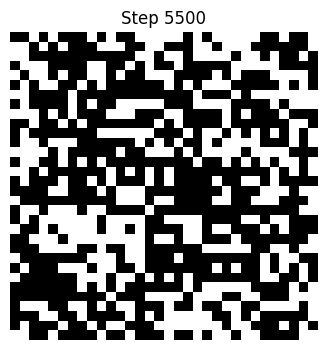

Step 6000: Energy = [-14759.9094038]


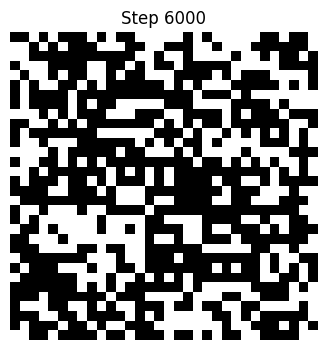

Step 6500: Energy = [-14836.11565763]


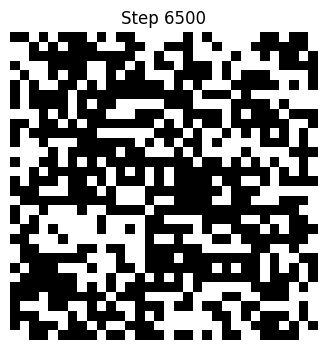

Step 7000: Energy = [-14879.41283315]


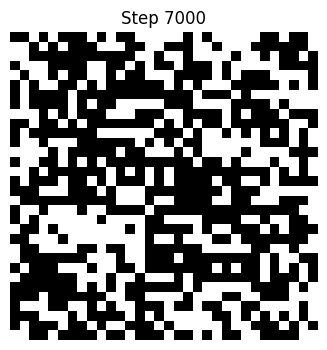

Step 7500: Energy = [-14945.15236704]


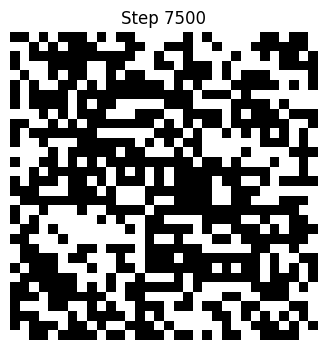

Converged after 8000 steps. (Stopped due to max iterations)
Converged after 8000 steps. (Stopped due to max iterations)


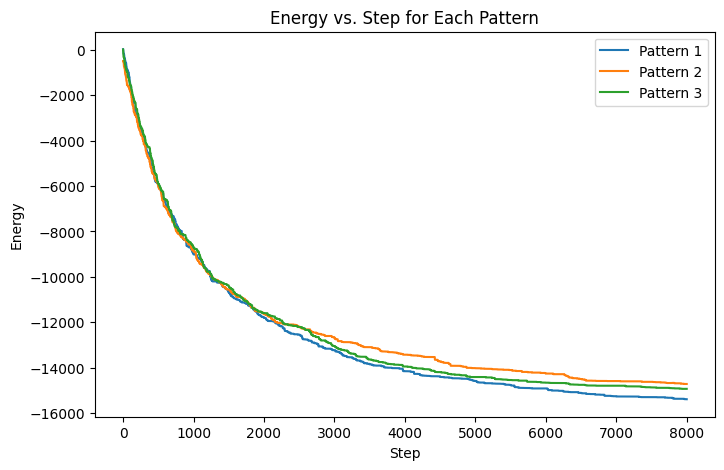

array([[-1.,  1.,  1.],
       [-1., -1.,  1.],
       [ 1.,  1., -1.],
       ...,
       [-1., -1.,  1.],
       [ 1.,  1., -1.],
       [-1., -1.,  1.]])

In [ ]:
# Personalised symmetric weight matrix
weights = (weights + weights.T) / 2

# New model
hopfield_sym = Hopfield(n_nodes=1024, weights=weights)

# Recalling patterns
hopfield_sym.recall(patterns[0].T, display=True, mode="asynchronous", no_change_limit=2000, max_iterations=8000)
hopfield_sym.recall(patterns_extracted.T, plot=True, mode="asynchronous", no_change_limit=2000, max_iterations=8000)

## 4) Distorsion Resistance

In [ ]:
def add_noise(pattern, rate):
    """
    Adds noise by randomly flipping rate % of the image pixels.
    """
    noisy_pattern = np.copy(pattern)
    num_pixels = pattern.size
    num_flipped = int(rate * num_pixels)

    flipped_indices = np.random.choice(range(num_pixels), num_flipped, replace=False)
    flipped_units = noisy_pattern[flipped_indices]
    #noisy_pattern[flipped_indices] *= -1
    noisy_pattern[flipped_indices] = np.random.choice([-1, 1], size=num_flipped)

    return noisy_pattern

Original pattern:


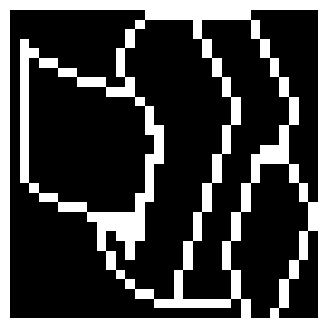

Noisy pattern:


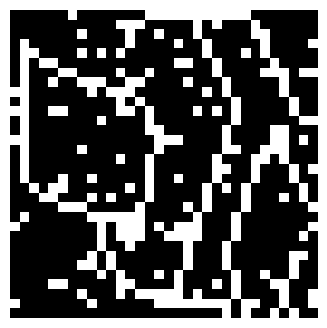

In [ ]:
print("Original pattern:")
pattern = patterns[0]
display_patterns([pattern])

print("Noisy pattern:")
noisy_pattern = add_noise(pattern, 0.2)
display_patterns([noisy_pattern])

In [ ]:
def evaluate_hopfield_vs_noise(hopfield, pattern, noise_levels, max_iterations=1, no_change_limit=1):
    """
    Evaluates the proportion of correct pixels restored for a single pattern across noise levels.
    """
    # Store the success rate (proportion of correct pixels) for each noise level
    success_rates = []

    for noise_level in noise_levels:
        # Add noise to the pattern
        noisy_pattern = add_noise(pattern, noise_level / 100)

        # Recall the pattern from the Hopfield network
        restored_pattern = hopfield.recall(noisy_pattern, max_iterations=max_iterations, no_change_limit=no_change_limit, verbose=False)
        restored_pattern = restored_pattern.reshape(-1)

        # Compute the proportion of correctly restored pixels
        correct_pixels = np.sum(np.sign(restored_pattern) == np.sign(pattern))
        total_pixels = restored_pattern.size
        success_rate = correct_pixels / total_pixels  # Proportion of correct pixels

        success_rates.append(success_rate)

    return success_rates

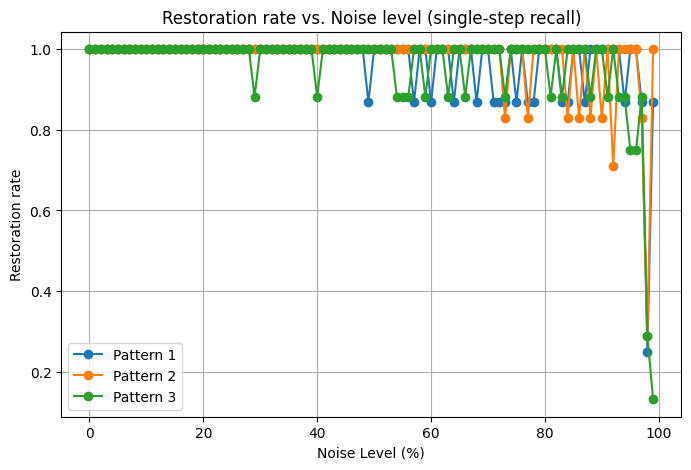

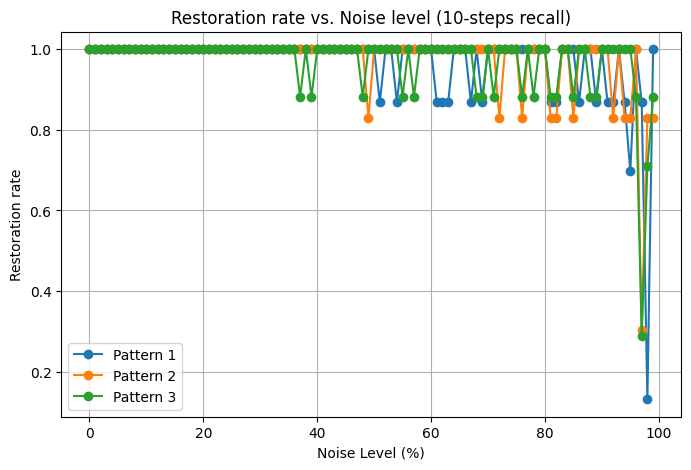

In [ ]:
# Define the noise levels and the Hopfield network
noise_levels = np.arange(0, 100, 1)  # Noise levels from 0% to 100%
hopfield = Hopfield(n_nodes=1024)

# Training
hopfield.train(patterns_extracted.T)

# Plot the results for each input pattern
plt.figure(figsize=(8, 5))
for i in range(3):
    # Evaluate success rate for each noise level and each pattern
    success_rates = evaluate_hopfield_vs_noise(hopfield, patterns[i], noise_levels)
    plt.plot(noise_levels, success_rates, label=f'Pattern {i+1}', marker='o', linestyle='-')

plt.legend()
plt.xlabel('Noise Level (%)')
plt.ylabel('Restoration rate')
plt.title('Restoration rate vs. Noise level (single-step recall)')
plt.grid()
plt.show()

# Plot the results for each input pattern
plt.figure(figsize=(8, 5))
for i in range(3):
    # Evaluate success rate for each noise level and each pattern
    success_rates = evaluate_hopfield_vs_noise(hopfield, patterns[i], noise_levels, max_iterations=10, no_change_limit=10)
    plt.plot(noise_levels, success_rates, label=f'Pattern {i+1}', marker='o', linestyle='-')

plt.legend()
plt.xlabel('Noise Level (%)')
plt.ylabel('Restoration rate')
plt.title(f'Restoration rate vs. Noise level ({10}-steps recall)')
plt.grid()
plt.show()

## 5) Capacity

In [ ]:
def generate_random_patterns(n_patterns, n_pixels=1024, biais=False):
    """
    Generates a random pattern of size 1024.
    """
    if biais:
        return np.sign(0.5 + np.random.randn(300, 100))
    else:
        return np.random.choice([-1, 1], size=(n_patterns, n_pixels))

In [ ]:
def compute_capacity(recall_rates, threshold=0.98):
    """
    Computes the capacity of the Hopfield network.
    """
    for i, value in enumerate(recall_rates):
        if value < threshold:
            return i
    return -1  # Return -1 if no element is less than 1.0

In [ ]:
def evaluate_hopfield(patterns, max_iterations=100, no_change_limit=20, noise_level=0.2, remove_self=False, verbose=False, activity=None, theta=None):
    """
    Evaluates the proportion of exact pattern recalls for both clean and noisy training patterns across capacity.
    """
    # Store the success rates (proportion of exact recalls) for clean and noisy patterns at each capacity
    clean_recall_rates = []
    noisy_recall_rates = []

    # Create noisy versions of the patterns
    noisy_patterns = patterns.copy()
    for j in range(patterns.shape[0]):
        noisy_patterns[j] = add_noise(patterns[j, :], rate=noise_level)

    for i in range(patterns.shape[0]):
        # Extract the first i patterns from clean and noisy sets
        extracted_patterns = patterns[:i+1,:].T
        extracted_noisy_patterns = noisy_patterns[:i+1,:].T

        # Create new Hopfield model
        hopfield = Hopfield(n_nodes=patterns.shape[-1])

        # Train the model with the first i patterns
        hopfield.train(extracted_patterns, remove_self=remove_self, activity=activity)

        # Recall the patterns from the Hopfield network
        restored_patterns_clean = hopfield.recall(extracted_patterns, max_iterations=max_iterations, no_change_limit=no_change_limit, verbose=False, theta=theta)
        restored_patterns_noisy = hopfield.recall(extracted_noisy_patterns, max_iterations=max_iterations, no_change_limit=no_change_limit, verbose=False, theta=theta)

        # Compute the exact recalls for clean patterns
        exact_recalls_clean = np.sum(np.array([np.array_equal(restored_patterns_clean[j], extracted_patterns[j]) for j in range(restored_patterns_clean.shape[0])]))
        total_clean_patterns = restored_patterns_clean.shape[0]
        clean_recall_rate = exact_recalls_clean / total_clean_patterns  # Proportion of exact pattern recalls for clean patterns

        # Compute the exact recalls for noisy patterns
        exact_recalls_noisy = np.sum(np.array([np.array_equal(restored_patterns_noisy[j], extracted_patterns[j]) for j in range(restored_patterns_noisy.shape[0])]))
        total_noisy_patterns = restored_patterns_noisy.shape[0]
        noisy_recall_rate = exact_recalls_noisy / total_noisy_patterns  # Proportion of exact pattern recalls for noisy patterns

        # Store the recall rates
        clean_recall_rates.append(clean_recall_rate)
        noisy_recall_rates.append(noisy_recall_rate)

    if verbose:
        # Print the capacity
        print(f"Clean capacity: {compute_capacity(clean_recall_rates)}")
        print(f"Noisy capacity: {compute_capacity(noisy_recall_rates)}")

    return clean_recall_rates, noisy_recall_rates

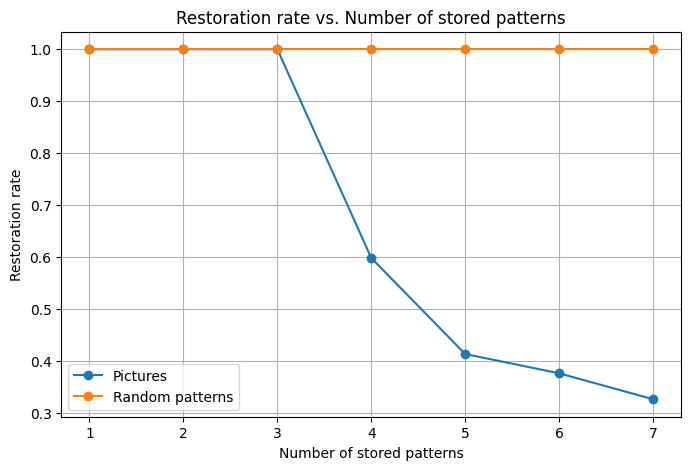

In [ ]:
# Generate pictures patterns
patterns_capacity = patterns[:7].copy()

# Generate random patterns
rd_patterns = generate_random_patterns(len(patterns_capacity))

# Plot the results
plt.figure(figsize=(8, 5))
success_rates_pic = evaluate_hopfield(patterns_capacity)[1]
plt.plot(range(1, patterns_capacity.shape[0]+1), success_rates_pic, label="Pictures", marker='o', linestyle='-')

success_rates_rd = evaluate_hopfield(rd_patterns)[1]
plt.plot(range(1, patterns_capacity.shape[0]+1), success_rates_rd, label="Random patterns", marker='o', linestyle='-')

plt.legend()
plt.xlabel('Number of stored patterns')
plt.ylabel('Restoration rate')
plt.title('Restoration rate vs. Number of stored patterns')
plt.grid()
plt.show()

With self connections:

Clean capacity: 11
Noisy capacity: 11


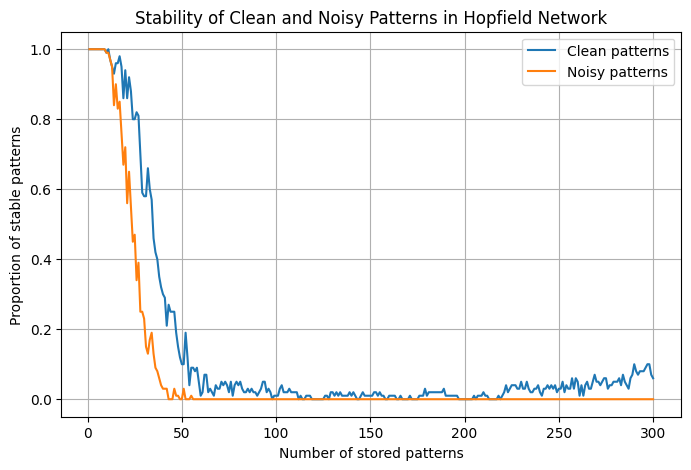

In [ ]:
# Generate random patterns
rd_patterns = generate_random_patterns(n_patterns=300, n_pixels=100)

# Evaluate the recall rates for clean and noisy patterns
clean_recall_rates, noisy_recall_rates = evaluate_hopfield(rd_patterns, noise_level=0.2, verbose=True)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(clean_recall_rates) + 1), clean_recall_rates, label="Clean patterns")
plt.plot(range(1, len(noisy_recall_rates) + 1), noisy_recall_rates, label="Noisy patterns")
plt.xlabel("Number of stored patterns")
plt.ylabel("Proportion of stable patterns")
plt.title("Stability of Clean and Noisy Patterns in Hopfield Network")
plt.grid()
plt.legend()
plt.show()

Without self connections:

Clean capacity: 10
Noisy capacity: 10


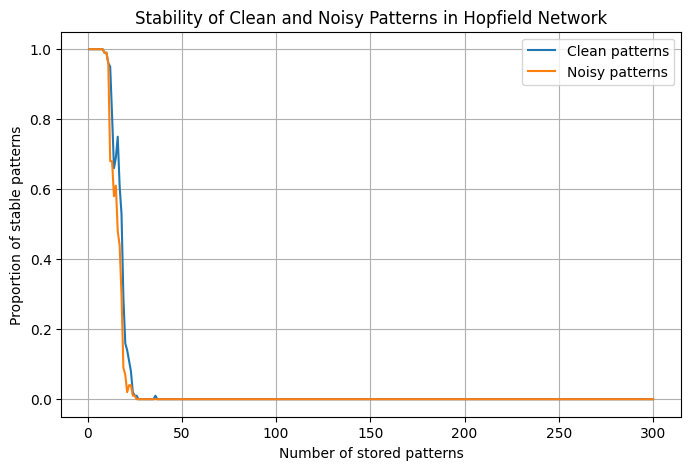

In [ ]:
# Evaluate the recall rates for clean and noisy patterns
clean_recall_rates, noisy_recall_rates = evaluate_hopfield(rd_patterns, noise_level=0.2, remove_self=True, verbose=True)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(clean_recall_rates) + 1), clean_recall_rates, label="Clean patterns")
plt.plot(range(1, len(noisy_recall_rates) + 1), noisy_recall_rates, label="Noisy patterns")
plt.xlabel("Number of stored patterns")
plt.ylabel("Proportion of stable patterns")
plt.title("Stability of Clean and Noisy Patterns in Hopfield Network")
plt.grid()
plt.legend()
plt.show()

With biased patterns:

Clean capacity: 4
Noisy capacity: 4


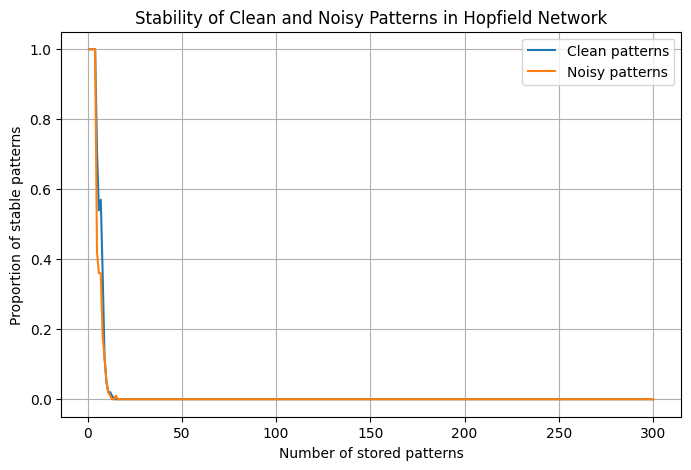

In [ ]:
# Generate random patterns
biaised_patterns = generate_random_patterns(n_patterns=300, n_pixels=100, biais=True)

# Evaluate the recall rates for clean and noisy patterns
clean_recall_rates, noisy_recall_rates = evaluate_hopfield(biaised_patterns, noise_level=0.2, remove_self=True, verbose=True)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(clean_recall_rates) + 1), clean_recall_rates, label="Clean patterns")
plt.plot(range(1, len(noisy_recall_rates) + 1), noisy_recall_rates, label="Noisy patterns")
plt.xlabel("Number of stored patterns")
plt.ylabel("Proportion of stable patterns")
plt.title("Stability of Clean and Noisy Patterns in Hopfield Network")
plt.grid()
plt.legend()
plt.show()

## 6) Sparse Patterns

In [ ]:
def generate_sparse_patterns(n_patterns, n_units, activity=0.5):
    """
    Generates binary patterns with a given activity level.
    """
    patterns = np.zeros((n_patterns, n_units), dtype=int)

    for i in range(n_patterns):
        # Randomly select indices to activate
        active_indices = np.random.choice(n_units, size=int(activity * n_units), replace=False)
        patterns[i, active_indices] = 1  # Set selected neurons to 1

    return patterns

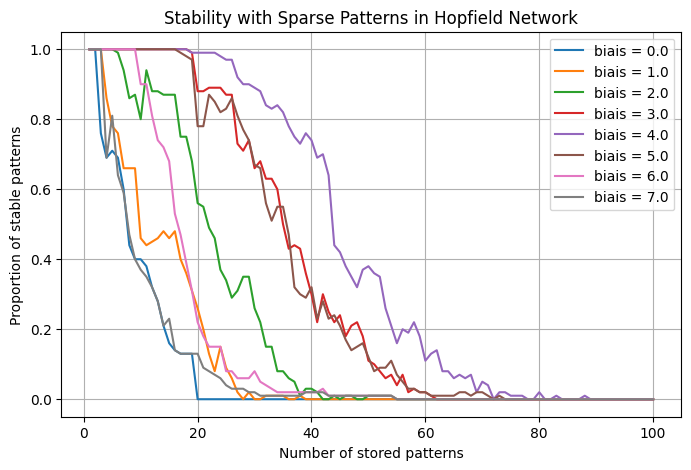

In [ ]:
# Generate sparse binary patterns
activity = 0.1
bin_patterns = generate_sparse_patterns(n_patterns=100, n_units=100, activity=activity)

# Iterate over values of biais
thetas = np.linspace(0, 7, 8)

# Evaluate the recall rates for clean and noisy patterns and plot the results
plt.figure(figsize=(8, 5))

for i in range(len(thetas)):
    clean_recall_rates = evaluate_hopfield(bin_patterns, noise_level=0.2, remove_self=True, activity=activity, theta=thetas[i])[0]
    plt.plot(range(1, len(bin_patterns) + 1), clean_recall_rates, label=f"biais = {thetas[i]}")

plt.legend()
plt.xlabel("Number of stored patterns")
plt.ylabel("Proportion of stable patterns")
plt.title("Stability with Sparse Patterns in Hopfield Network")
plt.grid()
plt.show()

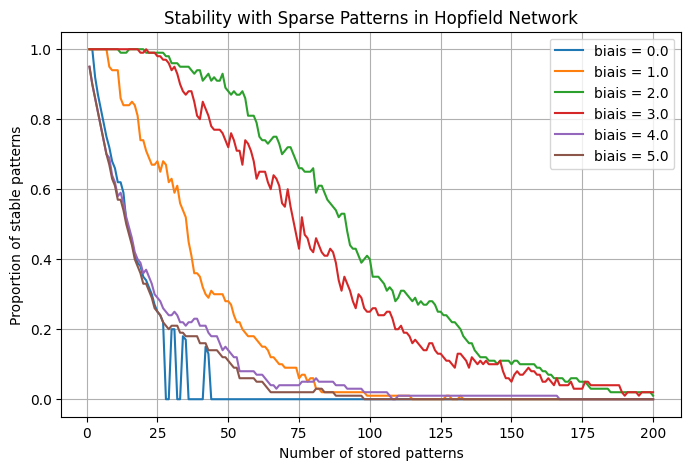

In [ ]:
# Generate sparse binary patterns
activity = 0.05
bin_patterns = generate_sparse_patterns(n_patterns=200, n_units=100, activity=activity)

# Iterate overs values of biais
thetas = np.linspace(0, 5, 6)

# Evaluate the recall rates for clean and noisy patterns and plot the results
plt.figure(figsize=(8, 5))

for i in range(len(thetas)):
    clean_recall_rates = evaluate_hopfield(bin_patterns, max_iterations=1, no_change_limit=1, noise_level=0.2, remove_self=True, activity=activity, theta=thetas[i])[0]
    plt.plot(range(1, len(bin_patterns) + 1), clean_recall_rates, label=f"biais = {thetas[i]}")

plt.legend()
plt.xlabel("Number of stored patterns")
plt.ylabel("Proportion of stable patterns")
plt.title("Stability with Sparse Patterns in Hopfield Network")
plt.grid()
plt.show()

In [ ]:
# Generate sparse binary patterns
activity = 0.01
bin_patterns = generate_sparse_patterns(n_patterns=200, n_units=100, activity=activity)

# Iterate overs values of biais
thetas = np.linspace(-5, 5, 11)

# Evaluate the recall rates for clean and noisy patterns and plot the results
plt.figure(figsize=(8, 5))

for i in range(len(thetas)):
    clean_recall_rates = evaluate_hopfield(bin_patterns, max_iterations=1, no_change_limit=1, noise_level=0.2, remove_self=True, activity=activity, theta=thetas[i])[0]
    plt.plot(range(1, len(bin_patterns) + 1), clean_recall_rates, label=f"biais = {thetas[i]}")

plt.legend()
plt.xlabel("Number of stored patterns")
plt.ylabel("Proportion of stable patterns")
plt.title("Stability with Sparse Patterns in Hopfield Network")
plt.grid()
plt.show()